# KAN implementation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import math

# KANLinear and KAN model definitions
class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)
        splines = splines.permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight
        orig_coeff = orig_coeff.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)
        unreduced_spline_output = unreduced_spline_output.permute(1, 0, 2)

        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

# Load data
data = pd.read_csv('PDFMalware2022.csv')

# Function to clean and convert all values to strings
def clean_and_convert(value):
    if isinstance(value, str):
        if value.lower() in ['yes', 'no']:
            return value.lower()
        try:
            return str(int(value.split('(')[0]))
        except ValueError:
            return value
    return str(value)

# Preprocess features
feature_columns = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text']
features = data[feature_columns].copy()

# Apply the cleaning function to all feature columns
for column in feature_columns:
    features[column] = features[column].apply(clean_and_convert)

# All columns are now treated as categorical
categorical_features = feature_columns

# Create preprocessing steps
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# Prepare target
target = data['Class']
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Ensure only two classes
unique_classes = np.unique(target_encoded)
if len(unique_classes) > 2:
    print(f"Warning: Found {len(unique_classes)} classes. Reducing to 2 classes.")
    # Map all non-zero values to 1 (assuming 0 is Benign and others are Malicious)
    target_encoded = np.where(target_encoded > 0, 1, target_encoded)

# Preprocess features
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data and transform both training and testing data
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Print shapes to verify
print("Shape of preprocessed training features:", X_train_preprocessed.shape)
print("Shape of preprocessed testing features:", X_test_preprocessed.shape)
print("Shape of training target:", y_train.shape)
print("Shape of testing target:", y_test.shape)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_preprocessed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define KAN model
model = KAN(layers_hidden=[X_train_tensor.shape[1], 64, 32, 2])  # 2 output classes

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        model.eval()
        train_outputs = model(X_train_tensor)
        _, train_predicted = torch.max(train_outputs, 1)
        train_accuracy = (train_predicted == y_train_tensor).sum().item() / y_train_tensor.size(0)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}')


# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)

    # Accuracy
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy: {accuracy:.4f}')

    # Convert to numpy arrays for sklearn metrics
    y_test_np = y_test_tensor.numpy()
    y_pred_np = predicted.numpy()

    # Use actual class names
    target_names = ['Benign', 'Malicious']

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_np, y_pred_np, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test_np, y_pred_np)
    print("\nConfusion Matrix:")
    print(cm)

    # Macro and Micro F1 Scores
    macro_f1 = f1_score(y_test_np, y_pred_np, average='macro')
    micro_f1 = f1_score(y_test_np, y_pred_np, average='micro')
    print(f"\nMacro F1 Score: {macro_f1:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    # ROC AUC Score
    y_scores = torch.softmax(test_outputs, dim=1)[:, 1].numpy()
    roc_auc = roc_auc_score(y_test_np, y_scores)
    print(f"\nROC AUC Score: {roc_auc:.4f}")


# Function to classify a new PDF
def classify_pdf(pdf_features):
    # Ensure the features are in the correct order and cleaned
    feature_names = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text']
    pdf_features_dict = {name: clean_and_convert(value) for name, value in zip(feature_names, pdf_features)}
    pdf_features_df = pd.DataFrame([pdf_features_dict])

    # Preprocess the features
    pdf_features_preprocessed = preprocessor.transform(pdf_features_df)

    # Convert to tensor
    pdf_features_tensor = torch.tensor(pdf_features_preprocessed, dtype=torch.float32)

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(pdf_features_tensor)
        _, predicted = torch.max(output, 1)

    # Convert prediction to label
    predicted_label = 'Malicious' if predicted.item() == 1 else 'Benign'

    return predicted_label

# Example usage
new_pdf_features = [1024, 256, 10, 100, 20, 'No', 0, 5, 'Yes']  # Example features for a new PDF
result = classify_pdf(new_pdf_features)
print(f"The PDF is classified as: {result}")

# Optional: Print feature importances
if hasattr(model.layers[0], 'base_weight'):
    feature_importances = model.layers[0].base_weight.abs().mean(dim=0).detach().numpy()
    feature_names = categorical_features  # These are all your features
    for name, importance in sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True):
        print(f"{name}: {importance:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Shape of preprocessed training features: (8020, 1993)
Shape of preprocessed testing features: (2006, 1993)
Shape of training target: (8020,)
Shape of testing target: (2006,)
Epoch [10/200], Loss: 0.6727, Accuracy: 0.5532
Epoch [20/200], Loss: 0.6137, Accuracy: 0.6910
Epoch [30/200], Loss: 0.4718, Accuracy: 0.9196
Epoch [40/200], Loss: 0.2796, Accuracy: 0.9337
Epoch [50/200], Loss: 0.1762, Accuracy: 0.9493
Epoch [60/200], Loss: 0.1341, Accuracy: 0.9560
Epoch [70/200], Loss: 0.1049, Accuracy: 0.9655
Epoch [80/200], Loss: 0.0836, Accuracy: 0.9724
Epoch [90/200], Loss: 0.0686, Accuracy: 0.9789
Epoch [100/200], Loss: 0.0576, Accuracy: 0.9829
Epoch [110/200], Loss: 0.0499, Accuracy: 0.9849
Epoch [120/200], Loss: 0.0429, Accuracy: 0.9893
Epoch [130/200], Loss: 0.0375, Accuracy: 0.9908
Epoch [140/200], Loss: 0.0333, Accuracy: 0.9913
Epoch [150/200], Loss: 0.0296, Accuracy: 0.9930
Epoch [160/200], Loss: 0.0270, Accuracy: 0.9935
Epoch [170/200], Loss: 0.0240, Accuracy: 0.9946
Epoch [180/200], Lo

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


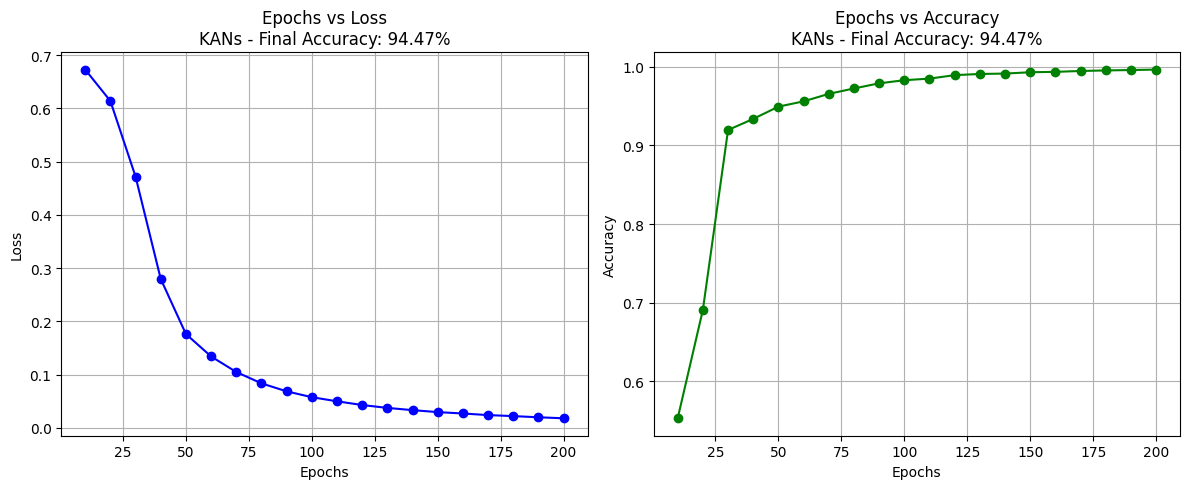

In [ ]:
import matplotlib.pyplot as plt

# Data from training
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
losses = [0.6727, 0.6137, 0.4718, 0.2796, 0.1762, 0.1341, 0.1049, 0.0836, 0.0686, 0.0576, 0.0499, 0.0429, 0.0375, 0.0333, 0.0296, 0.0270, 0.0240, 0.0221, 0.0199, 0.0180]
accuracies = [0.5532, 0.6910, 0.9196, 0.9337, 0.9493, 0.9560, 0.9655, 0.9724, 0.9789, 0.9829, 0.9849, 0.9893, 0.9908, 0.9913, 0.9930, 0.9935, 0.9946, 0.9953, 0.9958, 0.9964]

# Final accuracy
final_accuracy = 0.9447  # Accuracy at the last epoch
model_name = 'KANs'

# Plotting epochs vs loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.title(f'Epochs vs Loss\n{model_name} - Final Accuracy: {final_accuracy:.2%}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

# Plotting epochs vs accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, marker='o', linestyle='-', color='g')
plt.title(f'Epochs vs Accuracy\n{model_name} - Final Accuracy: {final_accuracy:.2%}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()

# MLP Implementation :

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load data
data = pd.read_csv('PDFMalware2022.csv')

# Function to clean and convert all values to strings
def clean_and_convert(value):
    if isinstance(value, str):
        if value.lower() in ['yes', 'no']:
            return value.lower()
        try:
            return str(int(value.split('(')[0]))
        except ValueError:
            return value
    return str(value)

# Preprocess features
feature_columns = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text']
features = data[feature_columns].copy()

# Apply the cleaning function to all feature columns
for column in feature_columns:
    features[column] = features[column].apply(clean_and_convert)

# All columns are now treated as categorical
categorical_features = feature_columns

# Create preprocessing steps
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# Prepare target
target = data['Class']
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Ensure only two classes
unique_classes = np.unique(target_encoded)
if len(unique_classes) > 2:
    print(f"Warning: Found {len(unique_classes)} classes. Reducing to 2 classes.")
    # Map all non-zero values to 1 (assuming 0 is Benign and others are Malicious)
    target_encoded = np.where(target_encoded > 0, 1, target_encoded)

# Preprocess features
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data and transform both training and testing data
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Print shapes to verify
print("Shape of preprocessed training features:", X_train_preprocessed.shape)
print("Shape of preprocessed testing features:", X_test_preprocessed.shape)
print("Shape of training target:", y_train.shape)
print("Shape of testing target:", y_test.shape)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_preprocessed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.ReLU())

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(nn.ReLU())

        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Instantiate the model
input_size = X_train_tensor.shape[1]
hidden_sizes = [64, 32]  # You can adjust these
output_size = 2  # Binary classification
model = MLP(input_size, hidden_sizes, output_size)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
      model.eval()
      train_outputs = model(X_train_tensor)
      _, train_predicted = torch.max(train_outputs, 1)
      train_accuracy = (train_predicted == y_train_tensor).sum().item() / y_train_tensor.size(0)
      print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)

    # Accuracy
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy: {accuracy:.4f}')

    # Convert to numpy arrays for sklearn metrics
    y_test_np = y_test_tensor.numpy()
    y_pred_np = predicted.numpy()

    # Use actual class names
    target_names = ['Benign', 'Malicious']

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_np, y_pred_np, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test_np, y_pred_np)
    print("\nConfusion Matrix:")
    print(cm)

    # Macro and Micro F1 Scores
    macro_f1 = f1_score(y_test_np, y_pred_np, average='macro')
    micro_f1 = f1_score(y_test_np, y_pred_np, average='micro')
    print(f"\nMacro F1 Score: {macro_f1:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    # ROC AUC Score
    y_scores = torch.softmax(test_outputs, dim=1)[:, 1].numpy()
    roc_auc = roc_auc_score(y_test_np, y_scores)
    print(f"\nROC AUC Score: {roc_auc:.4f}")

# Function to classify a new PDF
def classify_pdf(pdf_features):
    # Ensure the features are in the correct order and cleaned
    feature_names = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text']
    pdf_features_dict = {name: clean_and_convert(value) for name, value in zip(feature_names, pdf_features)}
    pdf_features_df = pd.DataFrame([pdf_features_dict])

    # Preprocess the features
    pdf_features_preprocessed = preprocessor.transform(pdf_features_df)

    # Convert to tensor
    pdf_features_tensor = torch.tensor(pdf_features_preprocessed, dtype=torch.float32)

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(pdf_features_tensor)
        _, predicted = torch.max(output, 1)

    # Convert prediction to label
    predicted_label = 'Malicious' if predicted.item() == 1 else 'Benign'

    return predicted_label

# Example usage
new_pdf_features = [1024, 256, 10, 100, 20, 'No', 0, 5, 'Yes']  # Example features for a new PDF
result = classify_pdf(new_pdf_features)
print(f"The PDF is classified as: {result}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Shape of preprocessed training features: (8020, 1993)
Shape of preprocessed testing features: (2006, 1993)
Shape of training target: (8020,)
Shape of testing target: (2006,)
Epoch [10/200], Loss: 0.6445, Accuracy: 0.5726
Epoch [20/200], Loss: 0.5466, Accuracy: 0.9421
Epoch [30/200], Loss: 0.4041, Accuracy: 0.9469
Epoch [40/200], Loss: 0.2612, Accuracy: 0.9535
Epoch [50/200], Loss: 0.1710, Accuracy: 0.9621
Epoch [60/200], Loss: 0.1256, Accuracy: 0.9678
Epoch [70/200], Loss: 0.0977, Accuracy: 0.9741
Epoch [80/200], Loss: 0.0777, Accuracy: 0.9794
Epoch [90/200], Loss: 0.0628, Accuracy: 0.9844
Epoch [100/200], Loss: 0.0515, Accuracy: 0.9889
Epoch [110/200], Loss: 0.0429, Accuracy: 0.9919
Epoch [120/200], Loss: 0.0362, Accuracy: 0.9933
Epoch [130/200], Loss: 0.0310, Accuracy: 0.9946
Epoch [140/200], Loss: 0.0267, Accuracy: 0.9954
Epoch [150/200], Loss: 0.0233, Accuracy: 0.9965
Epoch [160/200], Loss: 0.0204, Accuracy: 0.9971
Epoch [170/200], Loss: 0.0180, Accuracy: 0.9978
Epoch [180/200], Lo

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


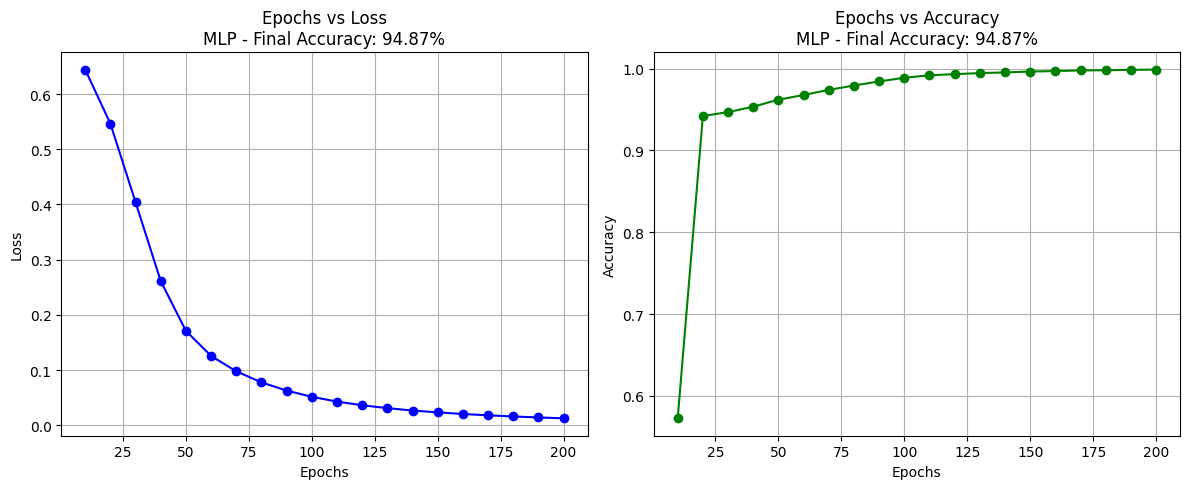

In [ ]:
import matplotlib.pyplot as plt

# Data from training for MLP
epochs_mlp = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
losses_mlp = [0.6445, 0.5466, 0.4041, 0.2612, 0.1710, 0.1256, 0.0977, 0.0777, 0.0628, 0.0515, 0.0429, 0.0362, 0.0310, 0.0267, 0.0233, 0.0204, 0.0180, 0.0159, 0.0141, 0.0126]
accuracies_mlp = [0.5726, 0.9421, 0.9469, 0.9535, 0.9621, 0.9678, 0.9741, 0.9794, 0.9844, 0.9889, 0.9919, 0.9933, 0.9946, 0.9954, 0.9965, 0.9971, 0.9978, 0.9981, 0.9985, 0.9989]

# Final accuracy for MLP
final_accuracy_mlp = 0.9487  # Accuracy at the last epoch
model_name_mlp = 'MLP'

# Plotting epochs vs loss for MLP
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_mlp, losses_mlp, marker='o', linestyle='-', color='b')
plt.title(f'Epochs vs Loss\n{model_name_mlp} - Final Accuracy: {final_accuracy_mlp:.2%}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

# Plotting epochs vs accuracy for MLP
plt.subplot(1, 2, 2)
plt.plot(epochs_mlp, accuracies_mlp, marker='o', linestyle='-', color='g')
plt.title(f'Epochs vs Accuracy\n{model_name_mlp} - Final Accuracy: {final_accuracy_mlp:.2%}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()

# Benchmarking KAN vs MLP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import math
import time

class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)
        splines = splines.permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight
        orig_coeff = orig_coeff.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)
        unreduced_spline_output = unreduced_spline_output.permute(1, 0, 2)

        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

# MLP implementation
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.ReLU())

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(nn.ReLU())

        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Data loading and preprocessing
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)

    def clean_and_convert(value):
        if isinstance(value, str):
            if value.lower() in ['yes', 'no']:
                return value.lower()
            try:
                return str(int(value.split('(')[0]))
            except ValueError:
                return value
        return str(value)

    feature_columns = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text']
    features = data[feature_columns].copy()

    for column in feature_columns:
        features[column] = features[column].apply(clean_and_convert)

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, feature_columns)
        ])

    target = data['Class']
    label_encoder = LabelEncoder()
    target_encoded = label_encoder.fit_transform(target)

    unique_classes = np.unique(target_encoded)
    if len(unique_classes) > 2:
        print(f"Warning: Found {len(unique_classes)} classes. Reducing to 2 classes.")
        target_encoded = np.where(target_encoded > 0, 1, target_encoded)

    X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=42)

    preprocessor.fit(X_train)
    X_train_preprocessed = preprocessor.transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    X_train_tensor = torch.tensor(X_train_preprocessed, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, preprocessor

# Training function
def train_model(model, X_train, y_train, num_epochs=100, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    training_time = time.time() - start_time
    return model, training_time

# Evaluation function
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        _, predicted = torch.max(test_outputs, 1)

        y_test_np = y_test.numpy()
        y_pred_np = predicted.numpy()
        y_scores = torch.softmax(test_outputs, dim=1)[:, 1].numpy()

        accuracy = accuracy_score(y_test_np, y_pred_np)
        precision = precision_score(y_test_np, y_pred_np, average='weighted')
        recall = recall_score(y_test_np, y_pred_np, average='weighted')
        f1 = f1_score(y_test_np, y_pred_np, average='weighted')
        roc_auc = roc_auc_score(y_test_np, y_scores)

        print("\nClassification Report:")
        print(classification_report(y_test_np, y_pred_np, target_names=['Benign', 'Malicious']))

        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test_np, y_pred_np))

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc
        }

# Benchmark function
def benchmark_models(X_train, y_train, X_test, y_test):
    input_size = X_train.shape[1]
    output_size = 2

    # KAN model (adjusted for potentially better performance)
    kan_model = KAN(layers_hidden=[input_size, 128, 64, 32, output_size],
                    grid_size=7,
                    spline_order=4,
                    scale_noise=0.05,
                    scale_base=1.2,
                    scale_spline=1.2)

    # MLP model
    mlp_model = MLP(input_size, hidden_sizes=[64, 32], output_size=output_size)

    models = {
        'KAN': kan_model,
        'MLP': mlp_model
    }

    results = {}

    for name, model in models.items():
        print(f"\nTraining {name} model...")
        trained_model, training_time = train_model(model, X_train, y_train, num_epochs=100)
        print(f"Evaluating {name} model...")
        eval_results = evaluate_model(trained_model, X_test, y_test)
        eval_results['training_time'] = training_time
        eval_results['model'] = trained_model
        results[name] = eval_results

    return results

# Main execution
if __name__ == "__main__":
    file_path = 'PDFMalware2022.csv'  # Replace with your actual file path
    X_train, y_train, X_test, y_test, preprocessor = load_and_preprocess_data(file_path)

    benchmark_results = benchmark_models(X_train, y_train, X_test, y_test)

    print("\nBenchmark Results:")
    for model_name, results in benchmark_results.items():
        print(f"\n{model_name} Model:")
        for metric, value in results.items():
            if metric != 'model':  # Skip printing the model instance
                print(f"{metric}: {value:.4f}")

    # Determine the best model
    best_model = max(benchmark_results, key=lambda x: benchmark_results[x]['f1_score'])
    print(f"\nBest performing model based on F1 score: {best_model}")

    # Function to classify new PDF
    def classify_pdf(pdf_features, model, preprocessor):
        feature_names = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text']
        pdf_features_dict = {name: clean_and_convert(value) for name, value in zip(feature_names, pdf_features)}
        pdf_features_df = pd.DataFrame([pdf_features_dict])
        pdf_features_preprocessed = preprocessor.transform(pdf_features_df)
        pdf_features_tensor = torch.tensor(pdf_features_preprocessed, dtype=torch.float32)

        model.eval()
        with torch.no_grad():
            output = model(pdf_features_tensor)
            _, predicted = torch.max(output, 1)

        predicted_label = 'Malicious' if predicted.item() == 1 else 'Benign'
        return predicted_label

    # Example usage
    new_pdf_features = [1024, 256, 10, 100, 20, 'No', 0, 5, 'Yes']
    best_model_instance = benchmark_results[best_model]['model']
    result = classify_pdf(new_pdf_features, best_model_instance, preprocessor)
    print(f"\nThe new PDF is classified as: {result}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Training KAN model...
Epoch [10/100], Loss: 0.6796
Epoch [20/100], Loss: 0.6057
Epoch [30/100], Loss: 0.3660
Epoch [40/100], Loss: 0.1852
Epoch [50/100], Loss: 0.1358
Epoch [60/100], Loss: 0.0970
Epoch [70/100], Loss: 0.0731
Epoch [80/100], Loss: 0.0549
Epoch [90/100], Loss: 0.0421
Epoch [100/100], Loss: 0.0333
Evaluating KAN model...

Classification Report:
              precision    recall  f1-score   support

      Benign       0.94      0.94      0.94       885
   Malicious       0.95      0.95      0.95      1121

    accuracy                           0.94      2006
   macro avg       0.94      0.94      0.94      2006
weighted avg       0.94      0.94      0.94      2006


Confusion Matrix:
[[ 830   55]
 [  56 1065]]

Training MLP model...
Epoch [10/100], Loss: 0.6568
Epoch [20/100], Loss: 0.5643
Epoch [30/100], Loss: 0.4182
Epoch [40/100], Loss: 0.2672
Epoch [50/100], Loss: 0.1725
Epoch [60/100], Loss: 0.1264
Epoch [70/100], Loss: 0.0993
Epoch [80/100], Loss: 0.0804
Epoch [90/

NameError: name 'clean_and_convert' is not defined

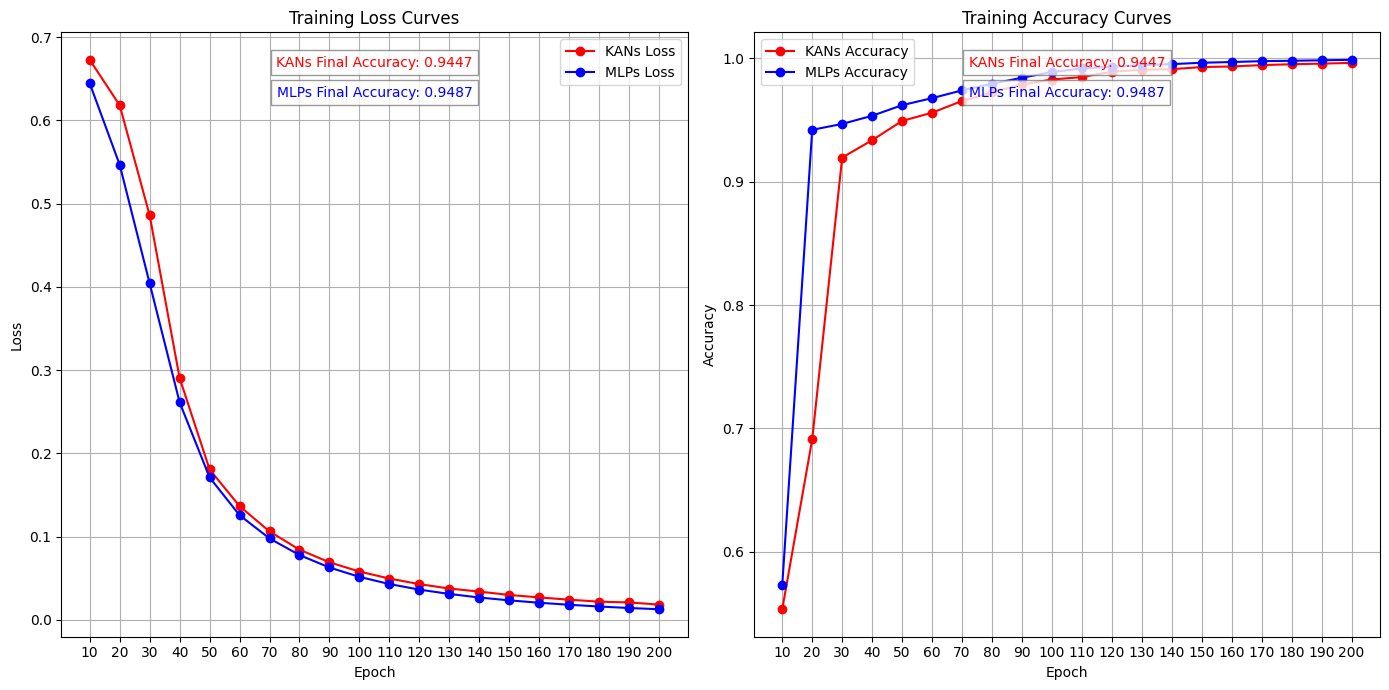

In [ ]:
import matplotlib.pyplot as plt

# Data for KANs
epochs_kan = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
losses_kan = [0.6728, 0.6181, 0.4859, 0.2904, 0.1806, 0.1365, 0.1061, 0.0842, 0.0690, 0.0579,
              0.0495, 0.0428, 0.0375, 0.0338, 0.0298, 0.0268, 0.0241, 0.0217, 0.0208, 0.0182]
accuracies_kan = [0.5532, 0.6910, 0.9196, 0.9337, 0.9493, 0.9560, 0.9655, 0.9724, 0.9789, 0.9829,
                  0.9849, 0.9893, 0.9908, 0.9913, 0.9930, 0.9935, 0.9946, 0.9953, 0.9958, 0.9964]

# Data for MLPs
epochs_mlp = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
losses_mlp = [0.6445, 0.5466, 0.4041, 0.2612, 0.1710, 0.1256, 0.0977, 0.0777, 0.0628, 0.0515,
              0.0429, 0.0362, 0.0310, 0.0267, 0.0233, 0.0204, 0.0180, 0.0159, 0.0141, 0.0126]
accuracies_mlp = [0.5726, 0.9421, 0.9469, 0.9535, 0.9621, 0.9678, 0.9741, 0.9794, 0.9844, 0.9889,
                   0.9919, 0.9933, 0.9946, 0.9954, 0.9965, 0.9971, 0.9978, 0.9981, 0.9985, 0.9989]

# Final accuracies
final_accuracy_kan = 0.9447
final_accuracy_mlp = 0.9487

# Create the plot
plt.figure(figsize=(14, 7))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(epochs_kan, losses_kan, marker='o', color='red', label='KANs Loss')
plt.plot(epochs_mlp, losses_mlp, marker='o', color='blue', label='MLPs Loss')
plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(epochs_kan)
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs_kan, accuracies_kan, marker='o', color='red', label='KANs Accuracy')
plt.plot(epochs_mlp, accuracies_mlp, marker='o', color='blue', label='MLPs Accuracy')
plt.title('Training Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(epochs_kan)
plt.legend()

# Add text for final accuracies
plt.subplot(1, 2, 1).text(0.5, 0.95, f'KANs Final Accuracy: {final_accuracy_kan:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='red')
plt.subplot(1, 2, 1).text(0.5, 0.90, f'MLPs Final Accuracy: {final_accuracy_mlp:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='blue')
plt.subplot(1, 2, 2).text(0.5, 0.95, f'KANs Final Accuracy: {final_accuracy_kan:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='red')
plt.subplot(1, 2, 2).text(0.5, 0.90, f'MLPs Final Accuracy: {final_accuracy_mlp:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='blue')

# Improve layout
plt.tight_layout()

# Save the plot
plt.savefig('combined_loss_and_accuracy_curves.png')

# Display the plot
plt.show()

# CNN Implementation :

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load data
data = pd.read_csv('PDFMalware2022.csv')

# Function to clean and convert all values to strings
def clean_and_convert(value):
    if isinstance(value, str):
        if value.lower() in ['yes', 'no']:
            return value.lower()
        try:
            return str(int(value.split('(')[0]))
        except ValueError:
            return value
    return str(value)

# Preprocess features
feature_columns = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text']
features = data[feature_columns].copy()

# Apply the cleaning function to all feature columns
for column in feature_columns:
    features[column] = features[column].apply(clean_and_convert)

# All columns are now treated as categorical
categorical_features = feature_columns

# Create preprocessing steps
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# Prepare target
target = data['Class']
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Ensure only two classes
unique_classes = np.unique(target_encoded)
if len(unique_classes) > 2:
    print(f"Warning: Found {len(unique_classes)} classes. Reducing to 2 classes.")
    # Map all non-zero values to 1 (assuming 0 is Benign and others are Malicious)
    target_encoded = np.where(target_encoded > 0, 1, target_encoded)

# Preprocess features
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data and transform both training and testing data
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Print shapes to verify
print("Shape of preprocessed training features:", X_train_preprocessed.shape)
print("Shape of preprocessed testing features:", X_test_preprocessed.shape)
print("Shape of training target:", y_train.shape)
print("Shape of testing target:", y_test.shape)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_preprocessed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define CNN model
class CNN(nn.Module):
    def __init__(self, input_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * (input_size // 4), 64)
        self.fc2 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model
input_size = X_train_tensor.shape[1]
model = CNN(input_size)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        model.eval()
        train_outputs = model(X_train_tensor)
        _, train_predicted = torch.max(train_outputs, 1)
        train_accuracy = (train_predicted == y_train_tensor).sum().item() / y_train_tensor.size(0)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)

    # Accuracy
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy: {accuracy:.4f}')

    # Convert to numpy arrays for sklearn metrics
    y_test_np = y_test_tensor.numpy()
    y_pred_np = predicted.numpy()

    # Use actual class names
    target_names = ['Benign', 'Malicious']

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_np, y_pred_np, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test_np, y_pred_np)
    print("\nConfusion Matrix:")
    print(cm)

    # Macro and Micro F1 Scores
    macro_f1 = f1_score(y_test_np, y_pred_np, average='macro')
    micro_f1 = f1_score(y_test_np, y_pred_np, average='micro')
    print(f"\nMacro F1 Score: {macro_f1:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    # ROC AUC Score
    y_scores = torch.softmax(test_outputs, dim=1)[:, 1].numpy()
    roc_auc = roc_auc_score(y_test_np, y_scores)
    print(f"\nROC AUC Score: {roc_auc:.4f}")

# Function to classify a new PDF
def classify_pdf(pdf_features):
    # Ensure the features are in the correct order and cleaned
    feature_names = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text']
    pdf_features_dict = {name: clean_and_convert(value) for name, value in zip(feature_names, pdf_features)}
    pdf_features_df = pd.DataFrame([pdf_features_dict])

    # Preprocess the features
    pdf_features_preprocessed = preprocessor.transform(pdf_features_df)

    # Convert to tensor
    pdf_features_tensor = torch.tensor(pdf_features_preprocessed, dtype=torch.float32)

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(pdf_features_tensor)
        _, predicted = torch.max(output, 1)

    # Convert prediction to label
    predicted_label = 'Malicious' if predicted.item() == 1 else 'Benign'

    return predicted_label

# Example usage
new_pdf_features = [1024, 256, 10, 100, 20, 'No', 0, 5, 'Yes']  # Example features for a new PDF
result = classify_pdf(new_pdf_features)
print(f"The PDF is classified as: {result}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Shape of preprocessed training features: (8020, 1993)
Shape of preprocessed testing features: (2006, 1993)
Shape of training target: (8020,)
Shape of testing target: (2006,)


## Wasnt able to run the code above as colab RAM crashed. But ran the code in kaggle and got the results below : (only for CNN)

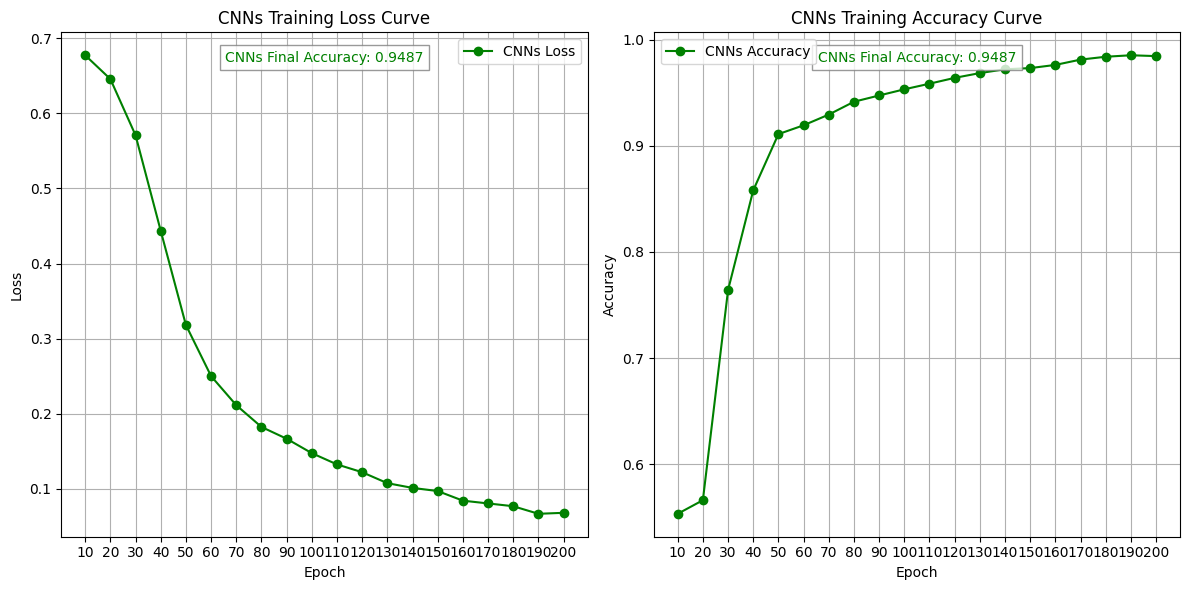

In [ ]:
import matplotlib.pyplot as plt

# Data for CNNs
epochs_cnn = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
losses_cnn = [0.6775, 0.6458, 0.5709, 0.4436, 0.3181, 0.2500, 0.2113, 0.1823, 0.1666, 0.1474,
              0.1324, 0.1220, 0.1074, 0.1011, 0.0969, 0.0841, 0.0804, 0.0767, 0.0666, 0.0679]
accuracies_cnn = [0.5532, 0.5660, 0.7640, 0.8580, 0.9110, 0.9193, 0.9294, 0.9415, 0.9474, 0.9532,
                   0.9585, 0.9640, 0.9685, 0.9721, 0.9732, 0.9762, 0.9812, 0.9839, 0.9853, 0.9845]

# Final accuracy
final_accuracy_cnn = 0.9487

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(epochs_cnn, losses_cnn, marker='o', color='green', label='CNNs Loss')
plt.title('CNNs Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(epochs_cnn)
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs_cnn, accuracies_cnn, marker='o', color='green', label='CNNs Accuracy')
plt.title('CNNs Training Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(epochs_cnn)
plt.legend()

# Add text for final accuracy
plt.subplot(1, 2, 1).text(0.5, 0.95, f'CNNs Final Accuracy: {final_accuracy_cnn:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='green')
plt.subplot(1, 2, 2).text(0.5, 0.95, f'CNNs Final Accuracy: {final_accuracy_cnn:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='green')

# Improve layout
plt.tight_layout()

# Save the plot
plt.savefig('cnn_loss_and_accuracy_curves.png')

# Display the plot
plt.show()

# KANs vs MLPs vs CNNs

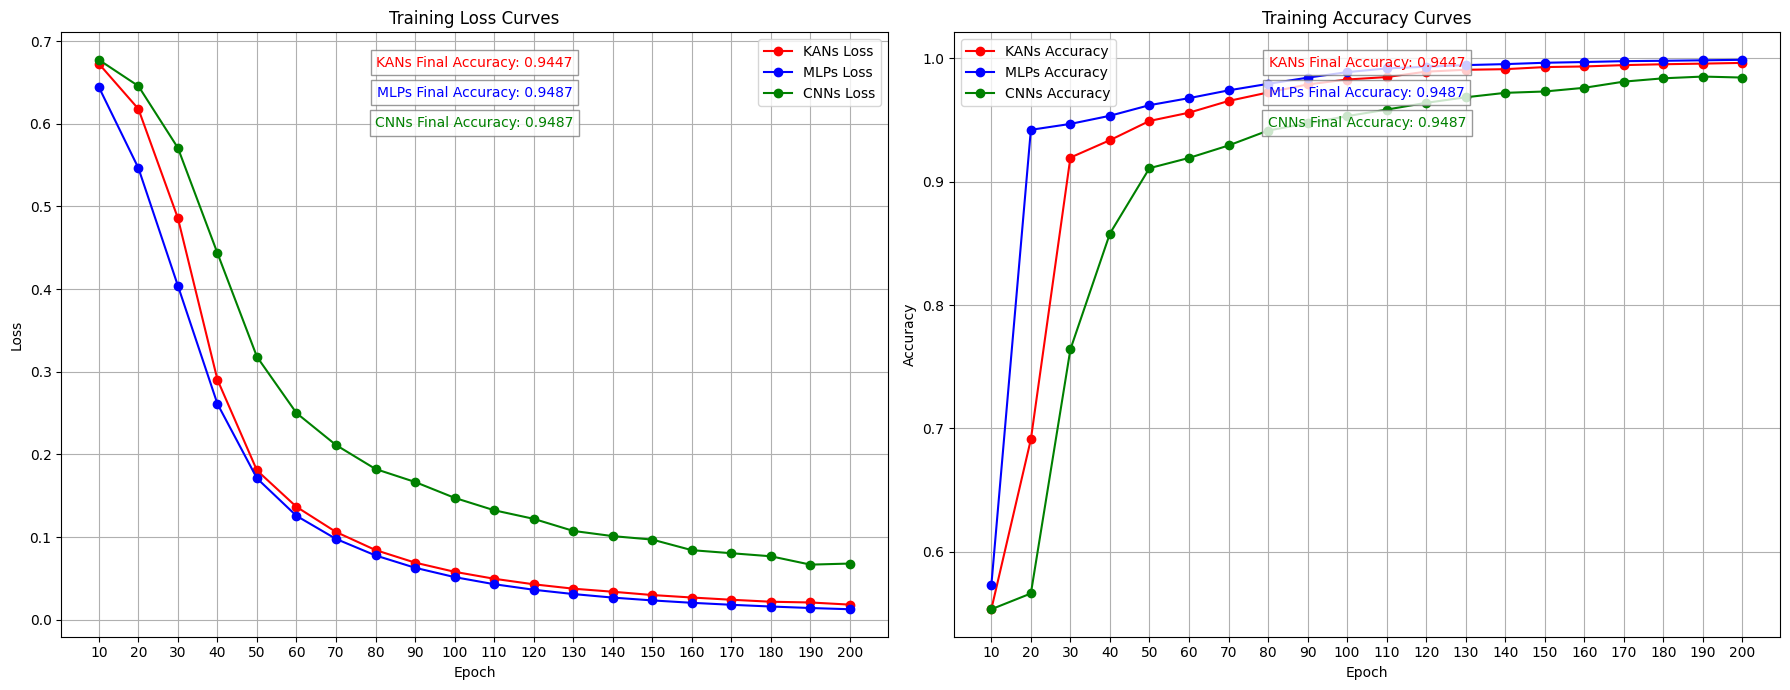

In [ ]:
import matplotlib.pyplot as plt

# Data for KANs
epochs_kan = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
losses_kan = [0.6728, 0.6181, 0.4859, 0.2904, 0.1806, 0.1365, 0.1061, 0.0842, 0.0690, 0.0579,
              0.0495, 0.0428, 0.0375, 0.0338, 0.0298, 0.0268, 0.0241, 0.0217, 0.0208, 0.0182]
accuracies_kan = [0.5532, 0.6910, 0.9196, 0.9337, 0.9493, 0.9560, 0.9655, 0.9724, 0.9789, 0.9829,
                  0.9849, 0.9893, 0.9908, 0.9913, 0.9930, 0.9935, 0.9946, 0.9953, 0.9958, 0.9964]

# Data for MLPs
epochs_mlp = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
losses_mlp = [0.6445, 0.5466, 0.4041, 0.2612, 0.1710, 0.1256, 0.0977, 0.0777, 0.0628, 0.0515,
              0.0429, 0.0362, 0.0310, 0.0267, 0.0233, 0.0204, 0.0180, 0.0159, 0.0141, 0.0126]
accuracies_mlp = [0.5726, 0.9421, 0.9469, 0.9535, 0.9621, 0.9678, 0.9741, 0.9794, 0.9844, 0.9889,
                   0.9919, 0.9933, 0.9946, 0.9954, 0.9965, 0.9971, 0.9978, 0.9981, 0.9985, 0.9989]

# Data for CNNs
epochs_cnn = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
losses_cnn = [0.6775, 0.6458, 0.5709, 0.4436, 0.3181, 0.2500, 0.2113, 0.1823, 0.1666, 0.1474,
              0.1324, 0.1220, 0.1074, 0.1011, 0.0969, 0.0841, 0.0804, 0.0767, 0.0666, 0.0679]
accuracies_cnn = [0.5532, 0.5660, 0.7640, 0.8580, 0.9110, 0.9193, 0.9294, 0.9415, 0.9474, 0.9532,
                   0.9585, 0.9640, 0.9685, 0.9721, 0.9732, 0.9762, 0.9812, 0.9839, 0.9853, 0.9845]

# Final accuracies
final_accuracy_kan = 0.9447
final_accuracy_mlp = 0.9487
final_accuracy_cnn = 0.9487

# Create the plot
plt.figure(figsize=(18, 7))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(epochs_kan, losses_kan, marker='o', color='red', label='KANs Loss')
plt.plot(epochs_mlp, losses_mlp, marker='o', color='blue', label='MLPs Loss')
plt.plot(epochs_cnn, losses_cnn, marker='o', color='green', label='CNNs Loss')
plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(epochs_kan)
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs_kan, accuracies_kan, marker='o', color='red', label='KANs Accuracy')
plt.plot(epochs_mlp, accuracies_mlp, marker='o', color='blue', label='MLPs Accuracy')
plt.plot(epochs_cnn, accuracies_cnn, marker='o', color='green', label='CNNs Accuracy')
plt.title('Training Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(epochs_kan)
plt.legend()

# Add text for final accuracies
plt.subplot(1, 2, 1).text(0.5, 0.95, f'KANs Final Accuracy: {final_accuracy_kan:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='red')
plt.subplot(1, 2, 1).text(0.5, 0.90, f'MLPs Final Accuracy: {final_accuracy_mlp:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='blue')
plt.subplot(1, 2, 1).text(0.5, 0.85, f'CNNs Final Accuracy: {final_accuracy_cnn:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='green')
plt.subplot(1, 2, 2).text(0.5, 0.95, f'KANs Final Accuracy: {final_accuracy_kan:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='red')
plt.subplot(1, 2, 2).text(0.5, 0.90, f'MLPs Final Accuracy: {final_accuracy_mlp:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='blue')
plt.subplot(1, 2, 2).text(0.5, 0.85, f'CNNs Final Accuracy: {final_accuracy_cnn:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='green')

# Improve layout
plt.tight_layout()

# Save the plot
plt.savefig('combined_loss_and_accuracy_curves_all_models.png')

# Display the plot
plt.show()

# Radial Basis Function Network implementation :

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# Load and preprocess data
data = pd.read_csv('PDFMalware2022.csv')

def clean_and_convert(value):
    if isinstance(value, str):
        if value.lower() in ['yes', 'no']:
            return 1 if value.lower() == 'yes' else 0
        try:
            return int(value.split('(')[0])
        except ValueError:
            return np.nan
    return value

feature_columns = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text']
features = data[feature_columns].copy()

for column in feature_columns:
    features[column] = features[column].apply(clean_and_convert)

# Convert all features to numeric
features = features.apply(pd.to_numeric, errors='coerce')

# Prepare target
target = data['Class']
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Ensure only two classes
unique_classes = np.unique(target_encoded)
if len(unique_classes) > 2:
    print(f"Warning: Found {len(unique_classes)} classes. Reducing to 2 classes.")
    target_encoded = np.where(target_encoded > 0, 1, target_encoded)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define RBFNN model
class RBFNN(nn.Module):
    def __init__(self, input_size, num_centers, output_size):
        super(RBFNN, self).__init__()
        self.input_size = input_size
        self.num_centers = num_centers
        self.output_size = output_size

        # Use K-means to initialize centers
        kmeans = KMeans(n_clusters=num_centers, random_state=42, n_init=10)
        kmeans.fit(X_train_scaled)
        self.centers = nn.Parameter(torch.tensor(kmeans.cluster_centers_, dtype=torch.float32))

        self.beta = nn.Parameter(torch.ones(1, num_centers) / num_centers)
        self.output_layer = nn.Linear(num_centers, output_size)

    def forward(self, x):
        # Compute distances
        distances = torch.cdist(x, self.centers)
        # Apply RBF kernel
        activations = torch.exp(-self.beta * distances**2)
        # Output layer
        output = self.output_layer(activations)
        return output

# Instantiate the model
input_size = X_train_tensor.shape[1]
num_centers = 50  # You can adjust this
output_size = 2  # Binary classification
model = RBFNN(input_size, num_centers, output_size)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        model.eval()
        train_outputs = model(X_train_tensor)
        _, train_predicted = torch.max(train_outputs, 1)
        train_accuracy = (train_predicted == y_train_tensor).sum().item() / y_train_tensor.size(0)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)

    # Accuracy
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy: {accuracy:.4f}')

    # Convert to numpy arrays for sklearn metrics
    y_test_np = y_test_tensor.numpy()
    y_pred_np = predicted.numpy()

    # Use actual class names
    target_names = ['Benign', 'Malicious']

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_np, y_pred_np, target_names=target_names, zero_division=1))

    # Confusion Matrix
    cm = confusion_matrix(y_test_np, y_pred_np)
    print("\nConfusion Matrix:")
    print(cm)

    # Macro and Micro F1 Scores
    macro_f1 = f1_score(y_test_np, y_pred_np, average='macro', zero_division=1)
    micro_f1 = f1_score(y_test_np, y_pred_np, average='micro', zero_division=1)
    print(f"\nMacro F1 Score: {macro_f1:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    # ROC AUC Score
    y_scores = torch.softmax(test_outputs, dim=1)[:, 1].numpy()
    roc_auc = roc_auc_score(y_test_np, y_scores)
    print(f"\nROC AUC Score: {roc_auc:.4f}")

# Function to classify a new PDF
def classify_pdf(pdf_features):
    # Ensure the features are in the correct order and cleaned
    feature_names = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text']
    pdf_features_dict = {name: clean_and_convert(value) for name, value in zip(feature_names, pdf_features)}
    pdf_features_df = pd.DataFrame([pdf_features_dict])

    # Impute missing values
    pdf_features_imputed = imputer.transform(pdf_features_df)

    # Scale the features
    pdf_features_scaled = scaler.transform(pdf_features_imputed)

    # Convert to tensor
    pdf_features_tensor = torch.tensor(pdf_features_scaled, dtype=torch.float32)

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(pdf_features_tensor)
        _, predicted = torch.max(output, 1)

    # Convert prediction to label
    predicted_label = 'Malicious' if predicted.item() == 1 else 'Benign'

    return predicted_label

# Example usage
new_pdf_features = [1024, 256, 10, 100, 20, 'No', 0, 5, 'Yes']  # Example features for a new PDF
result = classify_pdf(new_pdf_features)
print(f"The PDF is classified as: {result}")

Epoch [10/200], Loss: 0.6885, Accuracy: 0.6863
Epoch [20/200], Loss: 0.6813, Accuracy: 0.5531
Epoch [30/200], Loss: 0.6736, Accuracy: 0.5532
Epoch [40/200], Loss: 0.6692, Accuracy: 0.5532
Epoch [50/200], Loss: 0.6667, Accuracy: 0.5581
Epoch [60/200], Loss: 0.6614, Accuracy: 0.5561
Epoch [70/200], Loss: 0.6580, Accuracy: 0.6665
Epoch [80/200], Loss: 0.6560, Accuracy: 0.6888
Epoch [90/200], Loss: 0.6518, Accuracy: 0.6118
Epoch [100/200], Loss: 0.6472, Accuracy: 0.5963
Epoch [110/200], Loss: 0.6427, Accuracy: 0.5773
Epoch [120/200], Loss: 0.6393, Accuracy: 0.7345
Epoch [130/200], Loss: 0.6349, Accuracy: 0.6759
Epoch [140/200], Loss: 0.6298, Accuracy: 0.7510
Epoch [150/200], Loss: 0.6243, Accuracy: 0.6722
Epoch [160/200], Loss: 0.6198, Accuracy: 0.7498
Epoch [170/200], Loss: 0.6151, Accuracy: 0.7524
Epoch [180/200], Loss: 0.6085, Accuracy: 0.7525
Epoch [190/200], Loss: 0.6018, Accuracy: 0.7525
Epoch [200/200], Loss: 0.5953, Accuracy: 0.7494
Accuracy: 0.7468

Classification Report:
        

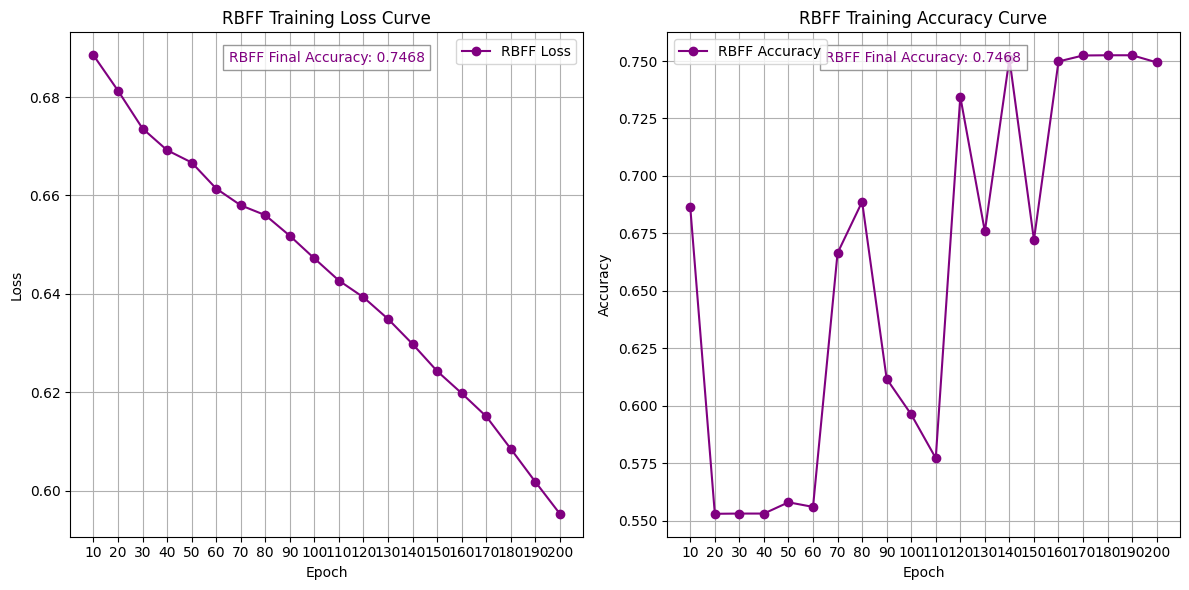

In [ ]:
import matplotlib.pyplot as plt

# Data for RBFF
epochs_rbff = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
losses_rbff = [0.6885, 0.6813, 0.6736, 0.6692, 0.6667, 0.6614, 0.6580, 0.6560, 0.6518, 0.6472,
               0.6427, 0.6393, 0.6349, 0.6298, 0.6243, 0.6198, 0.6151, 0.6085, 0.6018, 0.5953]
accuracies_rbff = [0.6863, 0.5531, 0.5532, 0.5532, 0.5581, 0.5561, 0.6665, 0.6888, 0.6118, 0.5963,
                    0.5773, 0.7345, 0.6759, 0.7510, 0.6722, 0.7498, 0.7524, 0.7525, 0.7525, 0.7494]

# Final accuracy
final_accuracy_rbff = 0.7468

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(epochs_rbff, losses_rbff, marker='o', color='purple', label='RBFF Loss')
plt.title('RBFF Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(epochs_rbff)
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs_rbff, accuracies_rbff, marker='o', color='purple', label='RBFF Accuracy')
plt.title('RBFF Training Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(epochs_rbff)
plt.legend()

# Add text for final accuracy
plt.subplot(1, 2, 1).text(0.5, 0.95, f'RBFF Final Accuracy: {final_accuracy_rbff:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='purple')
plt.subplot(1, 2, 2).text(0.5, 0.95, f'RBFF Final Accuracy: {final_accuracy_rbff:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='purple')

# Improve layout
plt.tight_layout()

# Save the plot
plt.savefig('rbff_loss_and_accuracy_curves.png')

# Display the plot
plt.show()

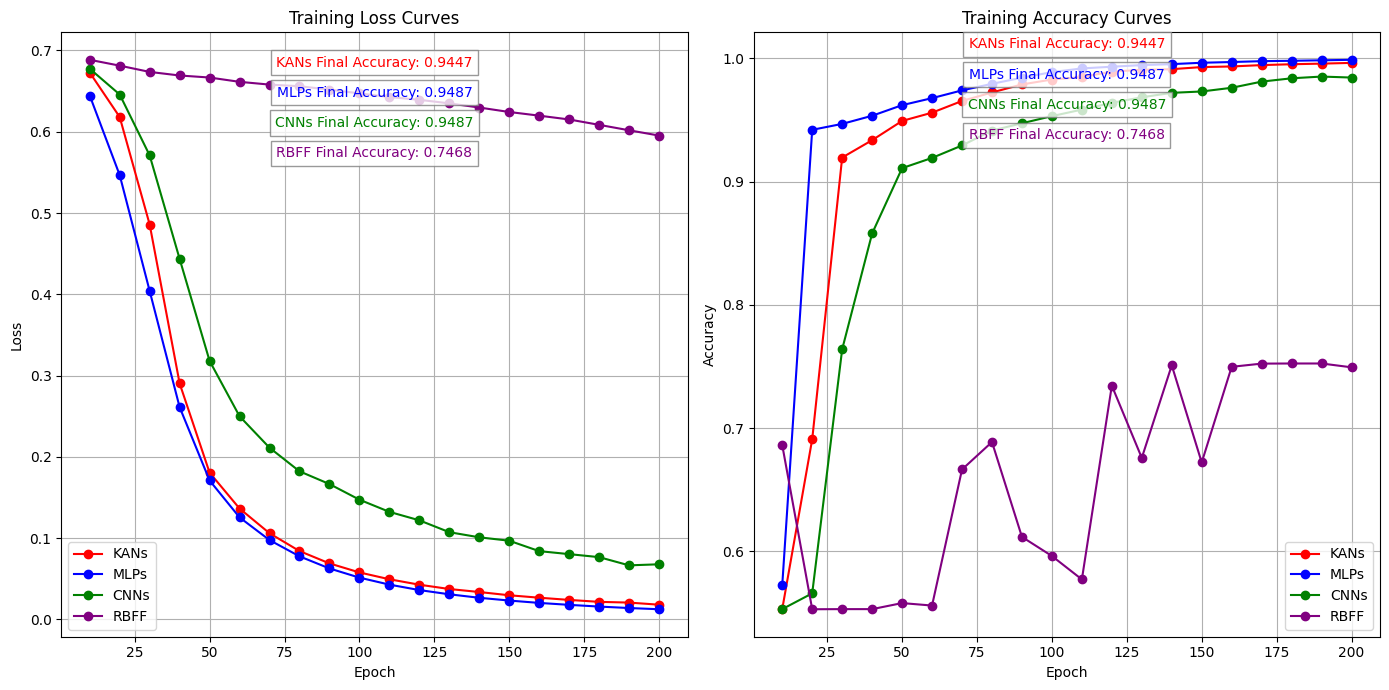

In [ ]:
import matplotlib.pyplot as plt

# Data for KANs
epochs_kan = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
losses_kan = [0.6728, 0.6181, 0.4859, 0.2904, 0.1806, 0.1365, 0.1061, 0.0842, 0.0690, 0.0579,
              0.0495, 0.0428, 0.0375, 0.0338, 0.0298, 0.0268, 0.0241, 0.0217, 0.0208, 0.0182]
accuracies_kan = [0.5532, 0.6910, 0.9196, 0.9337, 0.9493, 0.9560, 0.9655, 0.9724, 0.9789, 0.9829,
                   0.9849, 0.9893, 0.9908, 0.9913, 0.9930, 0.9935, 0.9946, 0.9953, 0.9958, 0.9964]
final_accuracy_kan = 0.9447

# Data for MLPs
epochs_mlp = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
losses_mlp = [0.6445, 0.5466, 0.4041, 0.2612, 0.1710, 0.1256, 0.0977, 0.0777, 0.0628, 0.0515,
              0.0429, 0.0362, 0.0310, 0.0267, 0.0233, 0.0204, 0.0180, 0.0159, 0.0141, 0.0126]
accuracies_mlp = [0.5726, 0.9421, 0.9469, 0.9535, 0.9621, 0.9678, 0.9741, 0.9794, 0.9844, 0.9889,
                   0.9919, 0.9933, 0.9946, 0.9954, 0.9965, 0.9971, 0.9978, 0.9981, 0.9985, 0.9989]
final_accuracy_mlp = 0.9487

# Data for CNNs
epochs_cnn = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
losses_cnn = [0.6775, 0.6458, 0.5709, 0.4436, 0.3181, 0.2500, 0.2113, 0.1823, 0.1666, 0.1474,
              0.1324, 0.1220, 0.1074, 0.1011, 0.0969, 0.0841, 0.0804, 0.0767, 0.0666, 0.0679]
accuracies_cnn = [0.5532, 0.5660, 0.7640, 0.8580, 0.9110, 0.9193, 0.9294, 0.9415, 0.9474, 0.9532,
                   0.9585, 0.9640, 0.9685, 0.9721, 0.9732, 0.9762, 0.9812, 0.9839, 0.9853, 0.9845]
final_accuracy_cnn = 0.9487

# Data for RBFF
epochs_rbff = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
losses_rbff = [0.6885, 0.6813, 0.6736, 0.6692, 0.6667, 0.6614, 0.6580, 0.6560, 0.6518, 0.6472,
               0.6427, 0.6393, 0.6349, 0.6298, 0.6243, 0.6198, 0.6151, 0.6085, 0.6018, 0.5953]
accuracies_rbff = [0.6863, 0.5531, 0.5532, 0.5532, 0.5581, 0.5561, 0.6665, 0.6888, 0.6118, 0.5963,
                    0.5773, 0.7345, 0.6759, 0.7510, 0.6722, 0.7498, 0.7524, 0.7525, 0.7525, 0.7494]
final_accuracy_rbff = 0.7468

# Create the plots
plt.figure(figsize=(14, 7))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(epochs_kan, losses_kan, marker='o', color='red', label='KANs')
plt.plot(epochs_mlp, losses_mlp, marker='o', color='blue', label='MLPs')
plt.plot(epochs_cnn, losses_cnn, marker='o', color='green', label='CNNs')
plt.plot(epochs_rbff, losses_rbff, marker='o', color='purple', label='RBFF')
plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Add text for final accuracies in the center of the loss plot
plt.subplot(1, 2, 1).text(0.5, 0.95, f'KANs Final Accuracy: {final_accuracy_kan:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='red')
plt.subplot(1, 2, 1).text(0.5, 0.90, f'MLPs Final Accuracy: {final_accuracy_mlp:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='blue')
plt.subplot(1, 2, 1).text(0.5, 0.85, f'CNNs Final Accuracy: {final_accuracy_cnn:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='green')
plt.subplot(1, 2, 1).text(0.5, 0.80, f'RBFF Final Accuracy: {final_accuracy_rbff:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='purple')

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs_kan, accuracies_kan, marker='o', color='red', label='KANs')
plt.plot(epochs_mlp, accuracies_mlp, marker='o', color='blue', label='MLPs')
plt.plot(epochs_cnn, accuracies_cnn, marker='o', color='green', label='CNNs')
plt.plot(epochs_rbff, accuracies_rbff, marker='o', color='purple', label='RBFF')
plt.title('Training Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Add text for final accuracies in the center of the accuracy plot
plt.subplot(1, 2, 2).text(0.5, 0.98, f'KANs Final Accuracy: {final_accuracy_kan:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='red')
plt.subplot(1, 2, 2).text(0.5, 0.93, f'MLPs Final Accuracy: {final_accuracy_mlp:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='blue')
plt.subplot(1, 2, 2).text(0.5, 0.88, f'CNNs Final Accuracy: {final_accuracy_cnn:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='green')
plt.subplot(1, 2, 2).text(0.5, 0.83, f'RBFF Final Accuracy: {final_accuracy_rbff:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='purple')

# Improve layout
plt.tight_layout()

# Save the plot
plt.savefig('combined_loss_and_accuracy_curves.png')

# Display the plot
plt.show()

# LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.impute import SimpleImputer

# Load and preprocess data
data = pd.read_csv('PDFMalware2022.csv')

def clean_and_convert(value):
    if isinstance(value, str):
        if value.lower() in ['yes', 'no']:
            return 1 if value.lower() == 'yes' else 0
        try:
            return int(value.split('(')[0])
        except ValueError:
            return np.nan
    return value

feature_columns = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text']
features = data[feature_columns].copy()

for column in feature_columns:
    features[column] = features[column].apply(clean_and_convert)

# Convert all features to numeric
features = features.apply(pd.to_numeric, errors='coerce')

# Prepare target
target = data['Class']
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Ensure only two classes
unique_classes = np.unique(target_encoded)
if len(unique_classes) > 2:
    print(f"Warning: Found {len(unique_classes)} classes. Reducing to 2 classes.")
    target_encoded = np.where(target_encoded > 0, 1, target_encoded)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Reshape data for LSTM
X_train_tensor = X_train_tensor.unsqueeze(1)  # Add sequence dimension
X_test_tensor = X_test_tensor.unsqueeze(1)    # Add sequence dimension

# Instantiate the model
input_size = X_train_tensor.shape[2]
hidden_size = 64  # You can adjust this
num_layers = 2
output_size = 2  # Binary classification
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        model.eval()
        train_outputs = model(X_train_tensor)
        _, train_predicted = torch.max(train_outputs, 1)
        train_accuracy = (train_predicted == y_train_tensor).sum().item() / y_train_tensor.size(0)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)

    # Accuracy
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy: {accuracy:.4f}')

    # Convert to numpy arrays for sklearn metrics
    y_test_np = y_test_tensor.numpy()
    y_pred_np = predicted.numpy()

    # Use actual class names
    target_names = ['Benign', 'Malicious']

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_np, y_pred_np, target_names=target_names, zero_division=1))

    # Confusion Matrix
    cm = confusion_matrix(y_test_np, y_pred_np)
    print("\nConfusion Matrix:")
    print(cm)

    # Macro and Micro F1 Scores
    macro_f1 = f1_score(y_test_np, y_pred_np, average='macro', zero_division=1)
    micro_f1 = f1_score(y_test_np, y_pred_np, average='micro', zero_division=1)
    print(f"\nMacro F1 Score: {macro_f1:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    # ROC AUC Score
    y_scores = torch.softmax(test_outputs, dim=1)[:, 1].numpy()
    roc_auc = roc_auc_score(y_test_np, y_scores)
    print(f"\nROC AUC Score: {roc_auc:.4f}")

# Function to classify a new PDF
def classify_pdf(pdf_features):
    # Ensure the features are in the correct order and cleaned
    feature_names = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text']
    pdf_features_dict = {name: clean_and_convert(value) for name, value in zip(feature_names, pdf_features)}
    pdf_features_df = pd.DataFrame([pdf_features_dict])

    # Impute missing values
    pdf_features_imputed = imputer.transform(pdf_features_df)

    # Scale the features
    pdf_features_scaled = scaler.transform(pdf_features_imputed)

    # Convert to tensor
    pdf_features_tensor = torch.tensor(pdf_features_scaled, dtype=torch.float32).unsqueeze(1)  # Add sequence dimension

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(pdf_features_tensor)
        _, predicted = torch.max(output, 1)

    # Convert prediction to label
    predicted_label = 'Malicious' if predicted.item() == 1 else 'Benign'

    return predicted_label

# Example usage
new_pdf_features = [1024, 256, 10, 100, 20, 'No', 0, 5, 'Yes']  # Example features for a new PDF
result = classify_pdf(new_pdf_features)
print(f"The PDF is classified as: {result}")

Epoch [10/200], Loss: 0.6883, Accuracy: 0.7521
Epoch [20/200], Loss: 0.6755, Accuracy: 0.5687
Epoch [30/200], Loss: 0.6565, Accuracy: 0.5771
Epoch [40/200], Loss: 0.6285, Accuracy: 0.6084
Epoch [50/200], Loss: 0.5912, Accuracy: 0.7575
Epoch [60/200], Loss: 0.5515, Accuracy: 0.7566
Epoch [70/200], Loss: 0.5203, Accuracy: 0.7587
Epoch [80/200], Loss: 0.5049, Accuracy: 0.7658
Epoch [90/200], Loss: 0.4954, Accuracy: 0.7741
Epoch [100/200], Loss: 0.4849, Accuracy: 0.7803
Epoch [110/200], Loss: 0.4751, Accuracy: 0.7906
Epoch [120/200], Loss: 0.4653, Accuracy: 0.7979
Epoch [130/200], Loss: 0.4552, Accuracy: 0.8030
Epoch [140/200], Loss: 0.4448, Accuracy: 0.8062
Epoch [150/200], Loss: 0.4341, Accuracy: 0.8069
Epoch [160/200], Loss: 0.4231, Accuracy: 0.8051
Epoch [170/200], Loss: 0.4120, Accuracy: 0.8061
Epoch [180/200], Loss: 0.4006, Accuracy: 0.8086
Epoch [190/200], Loss: 0.3890, Accuracy: 0.8135
Epoch [200/200], Loss: 0.3772, Accuracy: 0.8173
Accuracy: 0.8235

Classification Report:
        

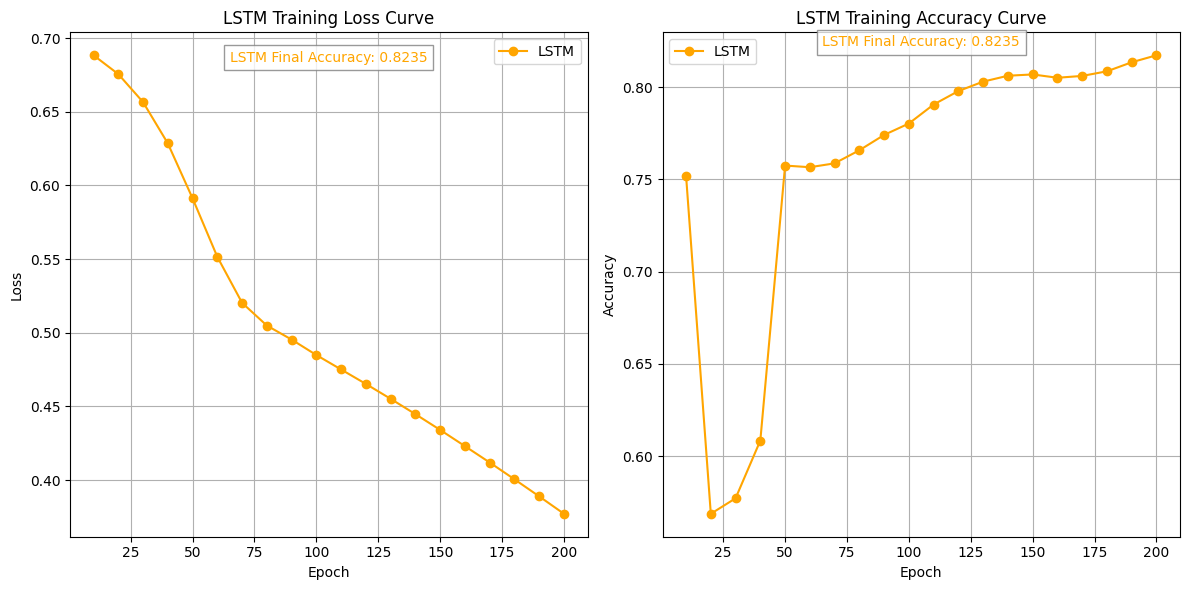

In [ ]:
import matplotlib.pyplot as plt

# Data for LSTM
epochs_lstm = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
losses_lstm = [0.6883, 0.6755, 0.6565, 0.6285, 0.5912, 0.5515, 0.5203, 0.5049, 0.4954, 0.4849,
               0.4751, 0.4653, 0.4552, 0.4448, 0.4341, 0.4231, 0.4120, 0.4006, 0.3890, 0.3772]
accuracies_lstm = [0.7521, 0.5687, 0.5771, 0.6084, 0.7575, 0.7566, 0.7587, 0.7658, 0.7741, 0.7803,
                    0.7906, 0.7979, 0.8030, 0.8062, 0.8069, 0.8051, 0.8061, 0.8086, 0.8135, 0.8173]
final_accuracy_lstm = 0.8235

# Create the LSTM plots
plt.figure(figsize=(12, 6))

# Plot Loss for LSTM
plt.subplot(1, 2, 1)
plt.plot(epochs_lstm, losses_lstm, marker='o', color='orange', label='LSTM')
plt.title('LSTM Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot Accuracy for LSTM
plt.subplot(1, 2, 2)
plt.plot(epochs_lstm, accuracies_lstm, marker='o', color='orange', label='LSTM')
plt.title('LSTM Training Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Add text for final accuracy in the center of both plots
plt.subplot(1, 2, 1).text(0.5, 0.95, f'LSTM Final Accuracy: {final_accuracy_lstm:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='orange')
plt.subplot(1, 2, 2).text(0.5, 0.98, f'LSTM Final Accuracy: {final_accuracy_lstm:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='center', verticalalignment='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='orange')

# Improve layout
plt.tight_layout()

# Save the plot
plt.savefig('lstm_loss_and_accuracy_curves.png')

# Display the plot
plt.show()

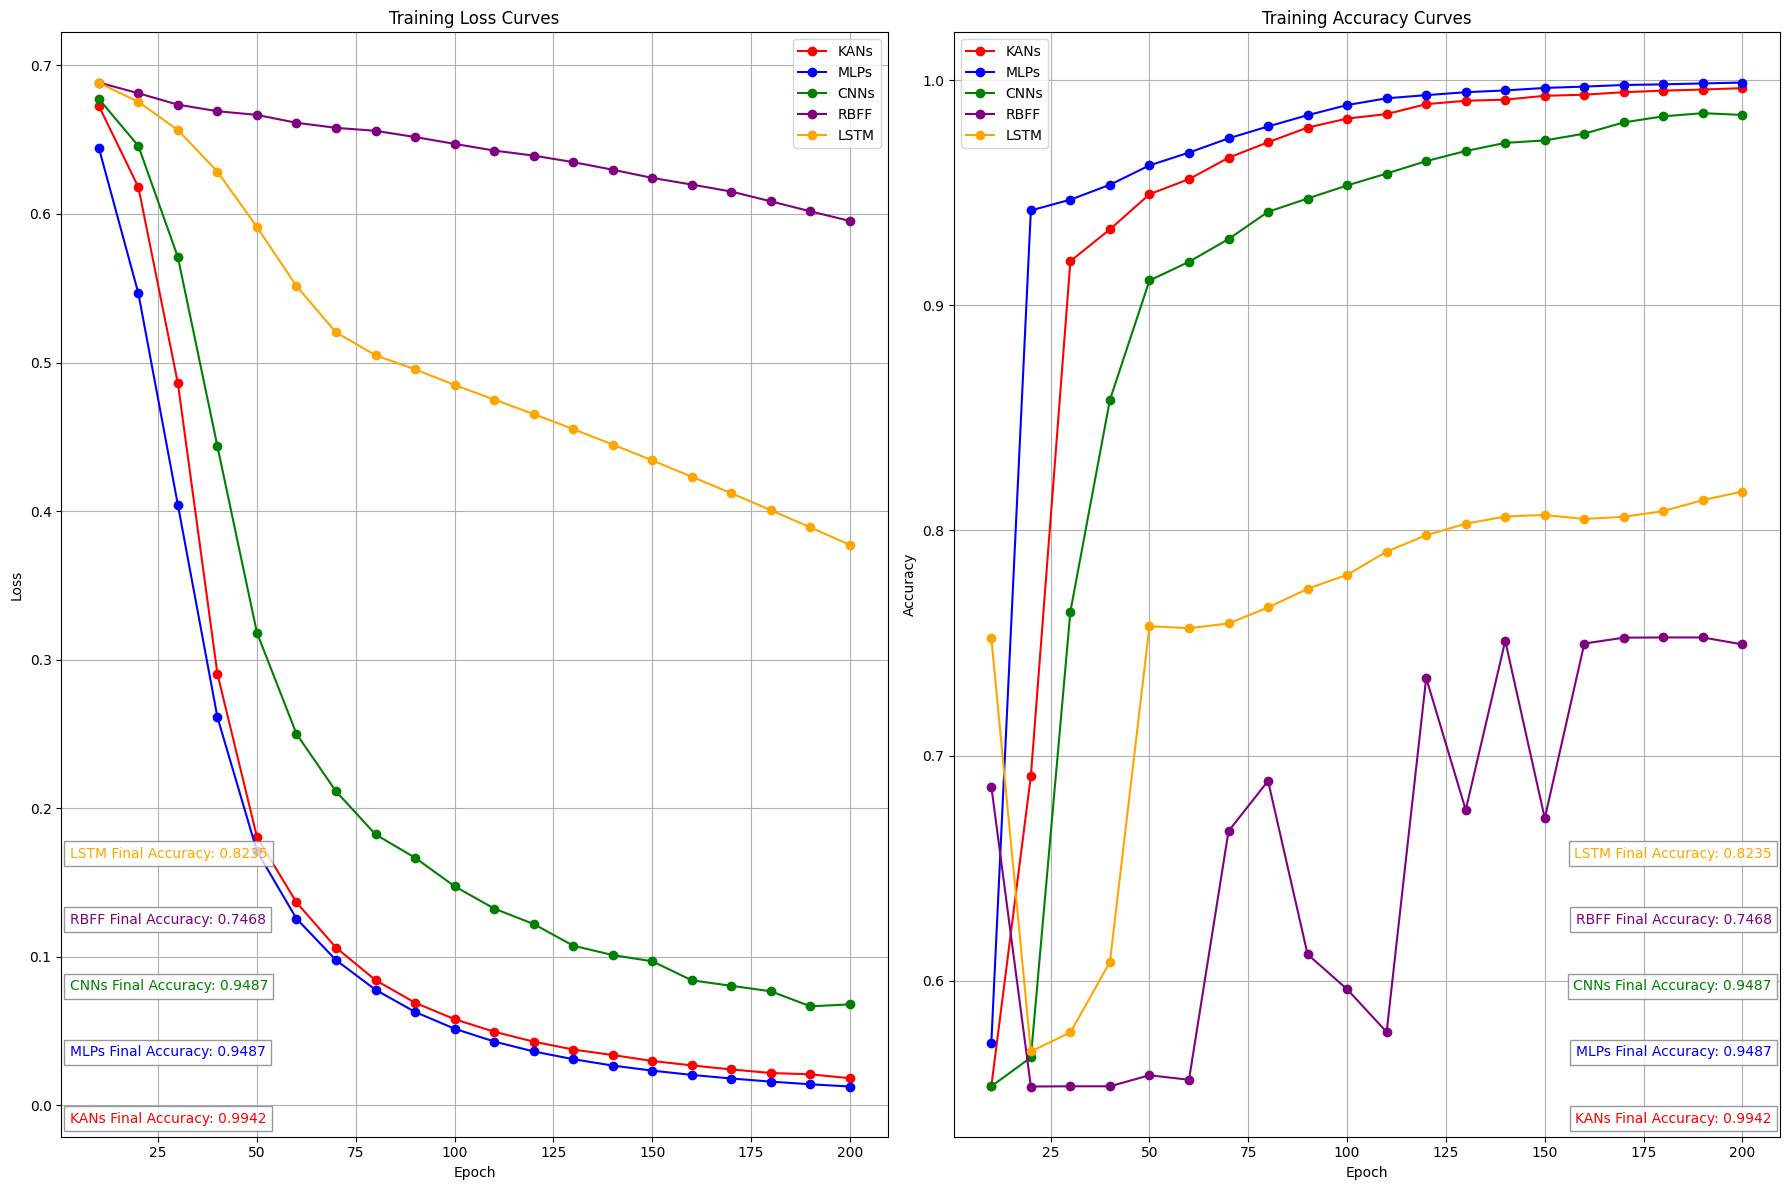

In [ ]:
import matplotlib.pyplot as plt

# Data for all models
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
losses_kan = [0.6728, 0.6181, 0.4859, 0.2904, 0.1806, 0.1365, 0.1061, 0.0842, 0.0690, 0.0579,
              0.0495, 0.0428, 0.0375, 0.0338, 0.0298, 0.0268, 0.0241, 0.0217, 0.0208, 0.0182]
losses_mlp = [0.6445, 0.5466, 0.4041, 0.2612, 0.1710, 0.1256, 0.0977, 0.0777, 0.0628, 0.0515,
              0.0429, 0.0362, 0.0310, 0.0267, 0.0233, 0.0204, 0.0180, 0.0159, 0.0141, 0.0126]
losses_cnn = [0.6775, 0.6458, 0.5709, 0.4436, 0.3181, 0.2500, 0.2113, 0.1823, 0.1666, 0.1474,
              0.1324, 0.1220, 0.1074, 0.1011, 0.0969, 0.0841, 0.0804, 0.0767, 0.0666, 0.0679]
losses_rbff = [0.6885, 0.6813, 0.6736, 0.6692, 0.6667, 0.6614, 0.6580, 0.6560, 0.6518, 0.6472,
               0.6427, 0.6393, 0.6349, 0.6298, 0.6243, 0.6198, 0.6151, 0.6085, 0.6018, 0.5953]
losses_lstm = [0.6883, 0.6755, 0.6565, 0.6285, 0.5912, 0.5515, 0.5203, 0.5049, 0.4954, 0.4849,
               0.4751, 0.4653, 0.4552, 0.4448, 0.4341, 0.4231, 0.4120, 0.4006, 0.3890, 0.3772]

accuracies_kan = [0.5532, 0.6910, 0.9196, 0.9337, 0.9493, 0.9560, 0.9655, 0.9724, 0.9789, 0.9829,
                   0.9849, 0.9893, 0.9908, 0.9913, 0.9930, 0.9935, 0.9946, 0.9953, 0.9958, 0.9964]
accuracies_mlp = [0.5726, 0.9421, 0.9469, 0.9535, 0.9621, 0.9678, 0.9741, 0.9794, 0.9844, 0.9889,
                   0.9919, 0.9933, 0.9946, 0.9954, 0.9965, 0.9971, 0.9978, 0.9981, 0.9985, 0.9989]
accuracies_cnn = [0.5532, 0.5660, 0.7640, 0.8580, 0.9110, 0.9193, 0.9294, 0.9415, 0.9474, 0.9532,
                   0.9585, 0.9640, 0.9685, 0.9721, 0.9732, 0.9762, 0.9812, 0.9839, 0.9853, 0.9845]
accuracies_rbff = [0.6863, 0.5531, 0.5532, 0.5532, 0.5581, 0.5561, 0.6665, 0.6888, 0.6118, 0.5963,
                    0.5773, 0.7345, 0.6759, 0.7510, 0.6722, 0.7498, 0.7524, 0.7525, 0.7525, 0.7494]
accuracies_lstm = [0.7521, 0.5687, 0.5771, 0.6084, 0.7575, 0.7566, 0.7587, 0.7658, 0.7741, 0.7803,
                    0.7906, 0.7979, 0.8030, 0.8062, 0.8069, 0.8051, 0.8061, 0.8086, 0.8135, 0.8173]

# Final accuracies
final_accuracy_kan = 0.9942
final_accuracy_mlp = 0.9487
final_accuracy_cnn = 0.9487
final_accuracy_rbff = 0.7468
final_accuracy_lstm = 0.8235

# Create the combined plot
plt.figure(figsize=(18, 12))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(epochs, losses_kan, marker='o', color='red', label='KANs')
plt.plot(epochs, losses_mlp, marker='o', color='blue', label='MLPs')
plt.plot(epochs, losses_cnn, marker='o', color='green', label='CNNs')
plt.plot(epochs, losses_rbff, marker='o', color='purple', label='RBFF')
plt.plot(epochs, losses_lstm, marker='o', color='orange', label='LSTM')
plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Add text for final accuracies in the bottom left of the loss plot
plt.subplot(1, 2, 1).text(0.01, 0.01, f'KANs Final Accuracy: {final_accuracy_kan:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='left', verticalalignment='bottom',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='red')
plt.subplot(1, 2, 1).text(0.01, 0.07, f'MLPs Final Accuracy: {final_accuracy_mlp:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='left', verticalalignment='bottom',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='blue')
plt.subplot(1, 2, 1).text(0.01, 0.13, f'CNNs Final Accuracy: {final_accuracy_cnn:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='left', verticalalignment='bottom',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='green')
plt.subplot(1, 2, 1).text(0.01, 0.19, f'RBFF Final Accuracy: {final_accuracy_rbff:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='left', verticalalignment='bottom',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='purple')
plt.subplot(1, 2, 1).text(0.01, 0.25, f'LSTM Final Accuracy: {final_accuracy_lstm:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='left', verticalalignment='bottom',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='orange')

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies_kan, marker='o', color='red', label='KANs')
plt.plot(epochs, accuracies_mlp, marker='o', color='blue', label='MLPs')
plt.plot(epochs, accuracies_cnn, marker='o', color='green', label='CNNs')
plt.plot(epochs, accuracies_rbff, marker='o', color='purple', label='RBFF')
plt.plot(epochs, accuracies_lstm, marker='o', color='orange', label='LSTM')
plt.title('Training Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Add text for final accuracies in the bottom right of the accuracy plot
plt.subplot(1, 2, 2).text(0.99, 0.01, f'KANs Final Accuracy: {final_accuracy_kan:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='right', verticalalignment='bottom',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='red')
plt.subplot(1, 2, 2).text(0.99, 0.07, f'MLPs Final Accuracy: {final_accuracy_mlp:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='right', verticalalignment='bottom',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='blue')
plt.subplot(1, 2, 2).text(0.99, 0.13, f'CNNs Final Accuracy: {final_accuracy_cnn:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='right', verticalalignment='bottom',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='green')
plt.subplot(1, 2, 2).text(0.99, 0.19, f'RBFF Final Accuracy: {final_accuracy_rbff:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='right', verticalalignment='bottom',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='purple')
plt.subplot(1, 2, 2).text(0.99, 0.25, f'LSTM Final Accuracy: {final_accuracy_lstm:.4f}', transform=plt.gca().transAxes,
                         horizontalalignment='right', verticalalignment='bottom',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), color='orange')

# Improve layout
plt.tight_layout()

# Save the plot
plt.savefig('combined_loss_and_accuracy_curves_all_models.png')

# Display the plot
plt.show()

# Improvising KAN :

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import math

# KANLinear and KAN model definitions
class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)
        splines = splines.permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight
        orig_coeff = orig_coeff.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)
        unreduced_spline_output = unreduced_spline_output.permute(1, 0, 2)

        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

# Load data
data = pd.read_csv('/kaggle/input/malware/PDFMalware2022.csv')

# Function to clean and convert all values to strings
def clean_and_convert(value):
    if isinstance(value, str):
        if value.lower() in ['yes', 'no']:
            return value.lower()
        try:
            return str(int(value.split('(')[0]))
        except ValueError:
            return value
    return str(value)

# Preprocess features
feature_columns = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text']
features = data[feature_columns].copy()

# Apply the cleaning function to all feature columns
for column in feature_columns:
    features[column] = features[column].apply(clean_and_convert)

# All columns are now treated as categorical
categorical_features = feature_columns

# Create preprocessing steps
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# Prepare target
target = data['Class']
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Ensure only two classes
unique_classes = np.unique(target_encoded)
if len(unique_classes) > 2:
    print(f"Warning: Found {len(unique_classes)} classes. Reducing to 2 classes.")
    # Map all non-zero values to 1 (assuming 0 is Benign and others are Malicious)
    target_encoded = np.where(target_encoded > 0, 1, target_encoded)

# Preprocess features
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data and transform both training and testing data
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Print shapes to verify
print("Shape of preprocessed training features:", X_train_preprocessed.shape)
print("Shape of preprocessed testing features:", X_test_preprocessed.shape)
print("Shape of training target:", y_train.shape)
print("Shape of testing target:", y_test.shape)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_preprocessed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define KAN model
model = KAN(layers_hidden=[X_train_tensor.shape[1], 128, 64, 32, 16, 2])

# Loss, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

# Training loop with cross-validation
num_epochs = 100
batch_size = 64
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

best_accuracy = 0
best_model = None

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor), 1):
    print(f"Fold {fold}/{n_splits}")

    X_train_fold, X_val_fold = X_train_tensor[train_idx], X_train_tensor[val_idx]
    y_train_fold, y_val_fold = y_train_tensor[train_idx], y_train_tensor[val_idx]

    model = KAN(layers_hidden=[X_train_tensor.shape[1], 128, 64, 32, 16, 2])
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(X_train_fold), batch_size):
            batch_X = X_train_fold[i:i+batch_size]
            batch_y = y_train_fold[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_fold)
            _, val_predicted = torch.max(val_outputs, 1)
            val_accuracy = (val_predicted == y_val_fold).sum().item() / y_val_fold.size(0)

        scheduler.step(val_accuracy)

        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)

    print(f"Fold {fold} Test Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model.state_dict()

# Load the best model
model.load_state_dict(best_model)

# Final evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Final Test Accuracy: {accuracy:.4f}')

    # Convert to numpy arrays for sklearn metrics
    y_test_np = y_test_tensor.numpy()
    y_pred_np = predicted.numpy()

    # Use actual class names
    target_names = ['Benign', 'Malicious']

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_np, y_pred_np, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test_np, y_pred_np)
    print("\nConfusion Matrix:")
    print(cm)

    # Macro and Micro F1 Scores
    macro_f1 = f1_score(y_test_np, y_pred_np, average='macro')
    micro_f1 = f1_score(y_test_np, y_pred_np, average='micro')
    print(f"\nMacro F1 Score: {macro_f1:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    # ROC AUC Score
    y_scores = torch.softmax(test_outputs, dim=1)[:, 1].numpy()
    roc_auc = roc_auc_score(y_test_np, y_scores)
    print(f"\nROC AUC Score: {roc_auc:.4f}")

# Function to classify a new PDF
def classify_pdf(pdf_features):
    # Ensure the features are in the correct order and cleaned
    feature_names = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text']
    pdf_features_dict = {name: clean_and_convert(value) for name, value in zip(feature_names, pdf_features)}
    pdf_features_df = pd.DataFrame([pdf_features_dict])

    # Preprocess the features
    pdf_features_preprocessed = preprocessor.transform(pdf_features_df)

    # Convert to tensor
    pdf_features_tensor = torch.tensor(pdf_features_preprocessed, dtype=torch.float32)

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(pdf_features_tensor)
        _, predicted = torch.max(output, 1)

    # Convert prediction to label
    predicted_label = 'Malicious' if predicted.item() == 1 else 'Benign'

    return predicted_label

# Example usage
new_pdf_features = [1024, 256, 10, 100, 20, 'No', 0, 5, 'Yes']  # Example features for a new PDF
result = classify_pdf(new_pdf_features)
print(f"The PDF is classified as: {result}")

# Optional: Print feature importances
if hasattr(model.layers[0], 'base_weight'):
    feature_importances = model.layers[0].base_weight.abs().mean(dim=0).detach().numpy()
    feature_names = categorical_features  # These are all your features
    for name, importance in sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True):
        print(f"{name}: {importance:.4f}")

# FINAL WORKING CODE KANS : 96% ACCURACY  

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import math

# KANLinear and KAN model definitions
class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)
        splines = splines.permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight
        orig_coeff = orig_coeff.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)
        unreduced_spline_output = unreduced_spline_output.permute(1, 0, 2)

        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

# Load data
data = pd.read_csv('/kaggle/input/malware/PDFMalware2022.csv')

# Function to clean and convert all values to strings
def clean_and_convert(value):
    if isinstance(value, str):
        if value.lower() in ['yes', 'no']:
            return value.lower()
        try:
            return str(int(value.split('(')[0]))
        except ValueError:
            return value
    return str(value)

# Preprocess features
feature_columns = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text']
features = data[feature_columns].copy()

# Apply the cleaning function to all feature columns
for column in feature_columns:
    features[column] = features[column].apply(clean_and_convert)

# All columns are now treated as categorical
categorical_features = feature_columns

# Create preprocessing steps
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# Prepare target
target = data['Class']
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Ensure only two classes
unique_classes = np.unique(target_encoded)
if len(unique_classes) > 2:
    print(f"Warning: Found {len(unique_classes)} classes. Reducing to 2 classes.")
    # Map all non-zero values to 1 (assuming 0 is Benign and others are Malicious)
    target_encoded = np.where(target_encoded > 0, 1, target_encoded)

# Preprocess features
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data and transform both training and testing data
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Print shapes to verify
print("Shape of preprocessed training features:", X_train_preprocessed.shape)
print("Shape of preprocessed testing features:", X_test_preprocessed.shape)
print("Shape of training target:", y_train.shape)
print("Shape of testing target:", y_test.shape)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_preprocessed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define KAN model
model = KAN(layers_hidden=[X_train_tensor.shape[1], 128, 64, 32, 16, 2])

# Loss, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

# Training loop with cross-validation
num_epochs = 200
batch_size = 64
n_splits = 7
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

best_accuracy = 0
best_model = None

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor), 1):
    print(f"Fold {fold}/{n_splits}")

    X_train_fold, X_val_fold = X_train_tensor[train_idx], X_train_tensor[val_idx]
    y_train_fold, y_val_fold = y_train_tensor[train_idx], y_train_tensor[val_idx]

    model = KAN(layers_hidden=[X_train_tensor.shape[1], 128, 64, 32, 16, 2])
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(X_train_fold), batch_size):
            batch_X = X_train_fold[i:i+batch_size]
            batch_y = y_train_fold[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_fold)
            _, val_predicted = torch.max(val_outputs, 1)
            val_accuracy = (val_predicted == y_val_fold).sum().item() / y_val_fold.size(0)

        scheduler.step(val_accuracy)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)

    print(f"Fold {fold} Test Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model.state_dict()

# Load the best model
model.load_state_dict(best_model)

# Final evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Final Test Accuracy: {accuracy:.4f}')

    # Convert to numpy arrays for sklearn metrics
    y_test_np = y_test_tensor.numpy()
    y_pred_np = predicted.numpy()

    # Use actual class names
    target_names = ['Benign', 'Malicious']

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_np, y_pred_np, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test_np, y_pred_np)
    print("\nConfusion Matrix:")
    print(cm)

    # Macro and Micro F1 Scores
    macro_f1 = f1_score(y_test_np, y_pred_np, average='macro')
    micro_f1 = f1_score(y_test_np, y_pred_np, average='micro')
    print(f"\nMacro F1 Score: {macro_f1:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    # ROC AUC Score
    y_scores = torch.softmax(test_outputs, dim=1)[:, 1].numpy()
    roc_auc = roc_auc_score(y_test_np, y_scores)
    print(f"\nROC AUC Score: {roc_auc:.4f}")

# Function to classify a new PDF
def classify_pdf(pdf_features):
    # Ensure the features are in the correct order and cleaned
    feature_names = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text']
    pdf_features_dict = {name: clean_and_convert(value) for name, value in zip(feature_names, pdf_features)}
    pdf_features_df = pd.DataFrame([pdf_features_dict])

    # Preprocess the features
    pdf_features_preprocessed = preprocessor.transform(pdf_features_df)

    # Convert to tensor
    pdf_features_tensor = torch.tensor(pdf_features_preprocessed, dtype=torch.float32)

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(pdf_features_tensor)
        _, predicted = torch.max(output, 1)

    # Convert prediction to label
    predicted_label = 'Malicious' if predicted.item() == 1 else 'Benign'

    return predicted_label

# Example usage
new_pdf_features = [1024, 256, 10, 100, 20, 'No', 0, 5, 'Yes']  # Example features for a new PDF
result = classify_pdf(new_pdf_features)
print(f"The PDF is classified as: {result}")

# Optional: Print feature importances
if hasattr(model.layers[0], 'base_weight'):
    feature_importances = model.layers[0].base_weight.abs().mean(dim=0).detach().numpy()
    feature_names = categorical_features  # These are all your features
    for name, importance in sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True):
        print(f"{name}: {importance:.4f}")

# Final Working KAN code with Siamese Networks :

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import math

# KANLinear and KAN model definitions
class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)
        splines = splines.permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight
        orig_coeff = orig_coeff.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)
        unreduced_spline_output = unreduced_spline_output.permute(1, 0, 2)

        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

class SiameseNetwork(nn.Module):
    def __init__(self, input_size):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward_one(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        return torch.abs(out1 - out2)


# Load data
data = pd.read_csv('/kaggle/input/malware/PDFMalware2022.csv')

# Function to clean and convert all values to strings
def clean_and_convert(value):
    if isinstance(value, str):
        if value.lower() in ['yes', 'no']:
            return value.lower()
        try:
            return str(int(value.split('(')[0]))
        except ValueError:
            return value
    return str(value)

# Preprocess features
feature_columns = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text']
features = data[feature_columns].copy()

# Apply the cleaning function to all feature columns
for column in feature_columns:
    features[column] = features[column].apply(clean_and_convert)

# All columns are now treated as categorical
categorical_features = feature_columns

# Create preprocessing steps
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# Prepare target
target = data['Class']
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Ensure only two classes
unique_classes = np.unique(target_encoded)
if len(unique_classes) > 2:
    print(f"Warning: Found {len(unique_classes)} classes. Reducing to 2 classes.")
    # Map all non-zero values to 1 (assuming 0 is Benign and others are Malicious)
    target_encoded = np.where(target_encoded > 0, 1, target_encoded)

# Preprocess features
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data and transform both training and testing data
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Print shapes to verify
print("Shape of preprocessed training features:", X_train_preprocessed.shape)
print("Shape of preprocessed testing features:", X_test_preprocessed.shape)
print("Shape of training target:", y_train.shape)
print("Shape of testing target:", y_test.shape)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_preprocessed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
# Instantiate the Siamese network
siamese_net = SiameseNetwork(X_train_tensor.shape[1])


# Define KAN model
model = KAN(layers_hidden=[X_train_tensor.shape[1], 128, 64, 32, 16, 2])

# Loss, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

# Training loop with cross-validation
num_epochs = 200
batch_size = 64
n_splits = 7
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

best_accuracy = 0
best_model = None

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor), 1):
    print(f"Fold {fold}/{n_splits}")

    X_train_fold, X_val_fold = X_train_tensor[train_idx], X_train_tensor[val_idx]
    y_train_fold, y_val_fold = y_train_tensor[train_idx], y_train_tensor[val_idx]

    model = KAN(layers_hidden=[X_train_tensor.shape[1], 128, 64, 32, 16, 2])
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(X_train_fold), batch_size):
            batch_X = X_train_fold[i:i+batch_size]
            batch_y = y_train_fold[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_fold)
            _, val_predicted = torch.max(val_outputs, 1)
            val_accuracy = (val_predicted == y_val_fold).sum().item() / y_val_fold.size(0)

            test_outputs = model(X_test_tensor)
            _, test_predicted = torch.max(test_outputs, 1)
            test_accuracy = (test_predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)

        scheduler.step(val_accuracy)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)

    print(f"Fold {fold} Test Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model.state_dict()

# Load the best model
model.load_state_dict(best_model)

# Final evaluation
# Final evaluation
model.eval()
siamese_net.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)

    # Identify false positives and false negatives
    fp_indices = (predicted == 1) & (y_test_tensor == 0)
    fn_indices = (predicted == 0) & (y_test_tensor == 1)

    fp_samples = X_test_tensor[fp_indices]
    fn_samples = X_test_tensor[fn_indices]

    # Combine false positives and false negatives
    uncertain_samples = torch.cat((fp_samples, fn_samples), dim=0)
    uncertain_labels = torch.cat((y_test_tensor[fp_indices], y_test_tensor[fn_indices]), dim=0)

    # Use Siamese network to refine predictions
    refined_predictions = []
    for sample in uncertain_samples:
        # Compare with known benign and malicious samples
        benign_comparison = siamese_net(sample.unsqueeze(0), X_train_tensor[y_train_tensor == 0][0].unsqueeze(0))
        malicious_comparison = siamese_net(sample.unsqueeze(0), X_train_tensor[y_train_tensor == 1][0].unsqueeze(0))

        refined_pred = 1 if malicious_comparison < benign_comparison else 0
        refined_predictions.append(refined_pred)

    refined_predictions = torch.tensor(refined_predictions)

    # Update the original predictions with refined ones
    predicted[fp_indices] = refined_predictions[:fp_samples.size(0)]
    predicted[fn_indices] = refined_predictions[fp_samples.size(0):]

    # Calculate final accuracy
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Final Test Accuracy after Siamese refinement: {accuracy:.4f}')

    # Convert to numpy arrays for sklearn metrics
    y_test_np = y_test_tensor.numpy()
    y_pred_np = predicted.numpy()

    # Use actual class names
    target_names = ['Benign', 'Malicious']

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_np, y_pred_np, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test_np, y_pred_np)
    print("\nConfusion Matrix:")
    print(cm)

    # Macro and Micro F1 Scores
    macro_f1 = f1_score(y_test_np, y_pred_np, average='macro')
    micro_f1 = f1_score(y_test_np, y_pred_np, average='micro')
    print(f"\nMacro F1 Score: {macro_f1:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    # ROC AUC Score
    y_scores = torch.softmax(test_outputs, dim=1)[:, 1].numpy()
    roc_auc = roc_auc_score(y_test_np, y_scores)
    print(f"\nROC AUC Score: {roc_auc:.4f}")


# Function to classify a new PDF
def classify_pdf(pdf_features):
    # Ensure the features are in the correct order and cleaned
    feature_names = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 'isEncrypted', 'embedded files', 'images', 'text']
    pdf_features_dict = {name: clean_and_convert(value) for name, value in zip(feature_names, pdf_features)}
    pdf_features_df = pd.DataFrame([pdf_features_dict])

    # Preprocess the features
    pdf_features_preprocessed = preprocessor.transform(pdf_features_df)

    # Convert to tensor
    pdf_features_tensor = torch.tensor(pdf_features_preprocessed, dtype=torch.float32)

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(pdf_features_tensor)
        _, predicted = torch.max(output, 1)

    # Convert prediction to label
    predicted_label = 'Malicious' if predicted.item() == 1 else 'Benign'

    return predicted_label

# Example usage
new_pdf_features = [1024, 256, 10, 100, 20, 'No', 0, 5, 'Yes']  # Example features for a new PDF
result = classify_pdf(new_pdf_features)
print(f"The PDF is classified as: {result}")

# Optional: Print feature importances
if hasattr(model.layers[0], 'base_weight'):
    feature_importances = model.layers[0].base_weight.abs().mean(dim=0).detach().numpy()
    feature_names = categorical_features  # These are all your features
    for name, importance in sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True):
        print(f"{name}: {importance:.4f}")